In [1]:
import numpy as np
import pickle
import torch
import sys
import matplotlib.pyplot as plt
from matplotlib import cm,colors
from warnings import filterwarnings
from tqdm import tqdm

filterwarnings('ignore')
sys.path.append('../src')

import scanpy as sc
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white', frameon=False)

from scipy.stats import pearsonr
from sklearn.metrics import r2_score

In [2]:
from inference import *
from utils import SCDATA_sampler, MMD_loss
from dataset import SCDataset
from torch.utils.data import DataLoader

# 1. load data

In [3]:
adata = sc.read_h5ad('../data/datasets/Norman2019_raw.h5ad')

# 2. load trained model

In [4]:
# CMVAE: run1675984750
# CVAE: run1691251907
# MVAE: run1691253564

In [5]:
# read different trained models here
savedir = '../result/run1675984750' 

with open(f'{savedir}/ptb_targets.pkl', 'rb') as f:
	ptb_targets = pickle.load(f)

model = torch.load(f'{savedir}/best_model.pt')

# set mode to the corresponding model/inference type
mode = 'CMVAE'

# 3. test single left out

## 3.1 generate samples

In [6]:
rmse, signerr, gt_y, pred_y, c_y, gt_x = evaluate_single_leftout(model, savedir, model.device, mode)
C_y = [','.join([str(l) for l in np.where(c_y[i]!=0)[0]]) for i in range(c_y.shape[0])]

In [7]:
# compute statistics
mmd_loss = {}
rmse_loss = {}
r2 = {}

loss =  MMD_loss(fix_sigma=1000, kernel_num=10)
for i in range(len(C_y)//32):
	y = torch.from_numpy(gt_y[i*32:(i+1)*32])
	y_hat = torch.from_numpy(pred_y[i*32:(i+1)*32])
	c = C_y[i*32]
	if c in mmd_loss.keys():
		mmd_loss[c].append(loss(y_hat, y).item())
		rmse_loss[c].append(np.sqrt(np.mean(((pred_y[i*32:(i+1)*32] - gt_y[i*32:(i+1)*32])**2)) / np.mean(((gt_y[i*32:(i+1)*32])**2))))
		r2[c].append(max(r2_score(np.mean(pred_y[i*32:(i+1)*32] , axis=0),np.mean(gt_y[i*32:(i+1)*32], axis=0)),0))
	else:
		mmd_loss[c] = [loss(y_hat, y).item()] 
		rmse_loss[c] = [np.sqrt(np.mean(((pred_y[i*32:(i+1)*32] - gt_y[i*32:(i+1)*32])**2)) / np.mean(((gt_y[i*32:(i+1)*32])**2)))]
		r2[c] = [max(r2_score(np.mean(pred_y[i*32:(i+1)*32] , axis=0),np.mean(gt_y[i*32:(i+1)*32], axis=0)),0)]
        
# summarize statistics
mmd_loss_summary = {}
rmse_loss_summary = {}
r2_summary ={}
for k in tqdm(mmd_loss.keys()):
	print(ptb_targets[int(k)], np.average(mmd_loss[k]), np.std(mmd_loss[k]))
	mmd_loss_summary[k] = (np.average(mmd_loss[k]), np.std(mmd_loss[k]))
	rmse_loss_summary[k] = (np.average(rmse_loss[k]), np.std(mmd_loss[k]))
	r2_summary[k] = (np.average(r2[k]), np.std(r2[k]))

100%|██████████| 14/14 [00:00<00:00, 9780.19it/s]

SET 0.4199391469919627 0.05679691147827011
BAK1 0.30673599284993147 0.009998962882068163
ETS2 0.31894228392699203 0.01746945576340046
CEBPE 0.37524604233793446 0.018052531296797906
UBASH3B 0.3058245743270906 0.008547220691374176
MAP2K6 0.31148905435648744 0.01640488988981647
SLC4A1 0.334656627040349 0.0217069441815131
KLF1 0.3031183867235007 0.005720581358997038
ELMSAN1 0.30703021393713487 0.012007294657592952
FOXF1 0.30824817863224446 0.0024751461364216215
OSR2 0.3250123620104944 0.010093449326224049
FOXA1 0.3313830722000776 0.008763957368622483
UBASH3A 0.31308927314073676 0.014427471001782393
C19orf26 0.33143974690186473 0.010994372747904543


In [8]:
print('mmd')
print('mean', np.mean([i[0] for i in mmd_loss_summary.values()]))
print('ste', np.std([i[0] for i in mmd_loss_summary.values()])/np.sqrt(len(mmd_loss_summary.keys())))

mmd
mean 0.32801106824120013
ste 0.00837006300772027


In [9]:
print('r2')
print('mean', np.mean([i[0] for i in r2_summary.values()]))
print('ste', np.std([i[0] for i in r2_summary.values()])/np.sqrt(len(rmse_loss_summary.keys())))

r2
mean 0.9841442950129606
ste 0.001291670674915927


In [10]:
print('rmse')
print('mean', np.mean([i[0] for i in rmse_loss_summary.values()]))
print('ste', np.std([i[0] for i in rmse_loss_summary.values()])/np.sqrt(len(rmse_loss_summary.keys())))

rmse
mean 0.562435351389649
ste 0.008026923183952967


## 3.2 umaps

In [11]:
ctrl_X = adata.X.toarray()
all_data = np.vstack([ctrl_X, gt_y, pred_y])

adata_new = sc.AnnData(all_data)

sc.tl.pca(adata_new, svd_solver='arpack')
sc.pp.neighbors(adata_new, n_neighbors=30, n_pcs=50)
sc.tl.umap(adata_new, min_dist=0.3) 

computing PCA
    with n_comps=50
    finished (0:00:15)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:42)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:56)


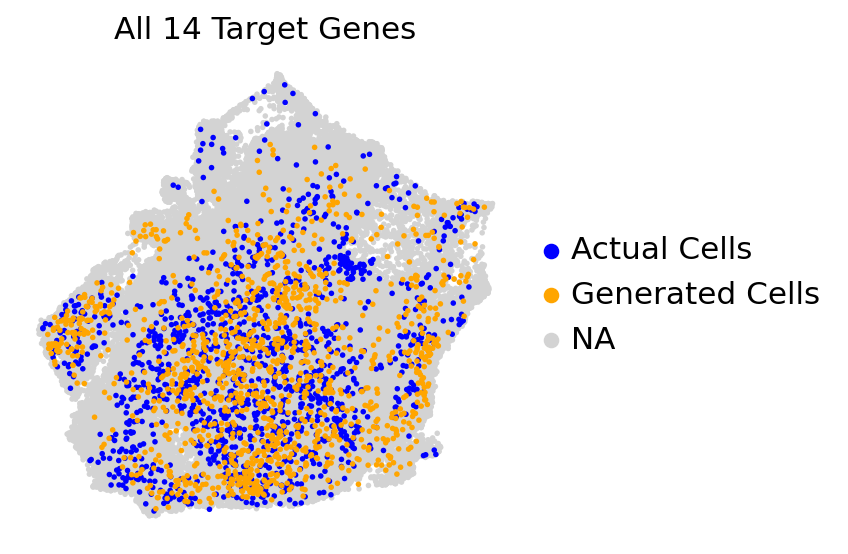

In [12]:
label = ['NA' for _ in range(len(ctrl_X))] + ['Actual Cells' for c in range(len(C_y))] + ['Generated Cells' for _ in range(len(C_y))]
adata_new.obs['label'] = label

sc.pl.umap(adata_new, 
           size=25, color=['label'], 
           groups=['Actual Cells', 'Generated Cells'], 
           legend_fontsize=14, title='All 14 Target Genes', 
           palette={'Actual Cells': 'blue', 
                    'Generated Cells': 'orange',
                    'NA': 'grey'
                    },
        #    save=f'_test_all_CMVAE-obs.pdf'
          );

In [ ]:
# generate for each target 
for c in set(C_y):
	label = ['NA' for _ in range(len(ctrl_X))] + ['Actual Cells' if C_y[i]==c else 'NA' for i in range(len(C_y))] + ['Generated Cells' if C_y[i]==c else 'NA' for i in range(len(C_y))]
	adata_new.obs['label'] = label
	sc.pl.umap(adata_new, size=50, color=['label'], 
               legend_fontsize=14, groups=['Actual Cells','Generated Cells'], 
               title=ptb_targets[int(c)], 
               palette={'Actual Cells': 'blue', 
                        'Generated Cells': 'orange',
                        'NA': 'grey'
                       },
               legend_loc=None,  
               save=f'_test_{ptb_targets[int(c)]}_CMVAE-obs.pdf'
              );

# 4. test double

## 4.1 generate samples

In [15]:
rmse, signerr, gt_y, pred_y, c_y, gt_x = evaluate_double(model, savedir, model.device, mode, temp=1)
C_y = [','.join([str(l) for l in np.where(c_y[i]!=0)[0]]) for i in range(c_y.shape[0])]

In [16]:
# compute statistics
mmd_loss = {}
rmse_loss = {}
r2 = {}

loss =  MMD_loss(fix_sigma=1000, kernel_num=10)
for i in range(len(C_y)//32):
	y = torch.from_numpy(gt_y[i*32:(i+1)*32])
	y_hat = torch.from_numpy(pred_y[i*32:(i+1)*32])
	c = C_y[i*32]
	if c in mmd_loss.keys():
		mmd_loss[c].append(loss(y_hat, y).item())
		rmse_loss[c].append(np.sqrt(np.mean(((pred_y[i*32:(i+1)*32] - gt_y[i*32:(i+1)*32])**2)) / np.mean(((gt_y[i*32:(i+1)*32])**2))))
		r2[c].append(max(r2_score(np.mean(pred_y[i*32:(i+1)*32] , axis=0),np.mean(gt_y[i*32:(i+1)*32], axis=0)),0))
	else:
		mmd_loss[c] = [loss(y_hat, y).item()] 
		rmse_loss[c] = [np.sqrt(np.mean(((pred_y[i*32:(i+1)*32] - gt_y[i*32:(i+1)*32])**2)) / np.mean(((gt_y[i*32:(i+1)*32])**2)))]
		r2[c] = [max(r2_score(np.mean(pred_y[i*32:(i+1)*32] , axis=0),np.mean(gt_y[i*32:(i+1)*32], axis=0)),0)]
        
# summarize statistics
mmd_loss_summary = {}
rmse_loss_summary = {}
r2_summary ={}
for k in tqdm(mmd_loss.keys()):
	mmd_loss_summary[k] = (np.average(mmd_loss[k]), np.std(mmd_loss[k]))
	rmse_loss_summary[k] = (np.average(rmse_loss[k]), np.std(mmd_loss[k]))
	r2_summary[k] = (np.average(r2[k]), np.std(r2[k]))

100%|██████████| 131/131 [00:00<00:00, 14671.27it/s]


In [17]:
print('mmd')
print('mean', np.mean([i[0] for i in mmd_loss_summary.values()]))
print('ste', np.std([i[0] for i in mmd_loss_summary.values()])/np.sqrt(len(mmd_loss_summary.keys())))

mmd
mean 0.4290911036402378
ste 0.006025188786205493


In [18]:
print('r2')
print('mean', np.mean([i[0] for i in r2_summary.values()]))
print('ste', np.std([i[0] for i in r2_summary.values()])/np.sqrt(len(rmse_loss_summary.keys())))

r2
mean 0.9664271497405721
ste 0.001362319389158225


In [19]:
print('rmse')
print('mean', np.mean([i[0] for i in rmse_loss_summary.values()]))
print('ste', np.std([i[0] for i in rmse_loss_summary.values()])/np.sqrt(len(rmse_loss_summary.keys())))

rmse
mean 0.6261060115303617
ste 0.004528354186453708


## 4.2 plot statistics

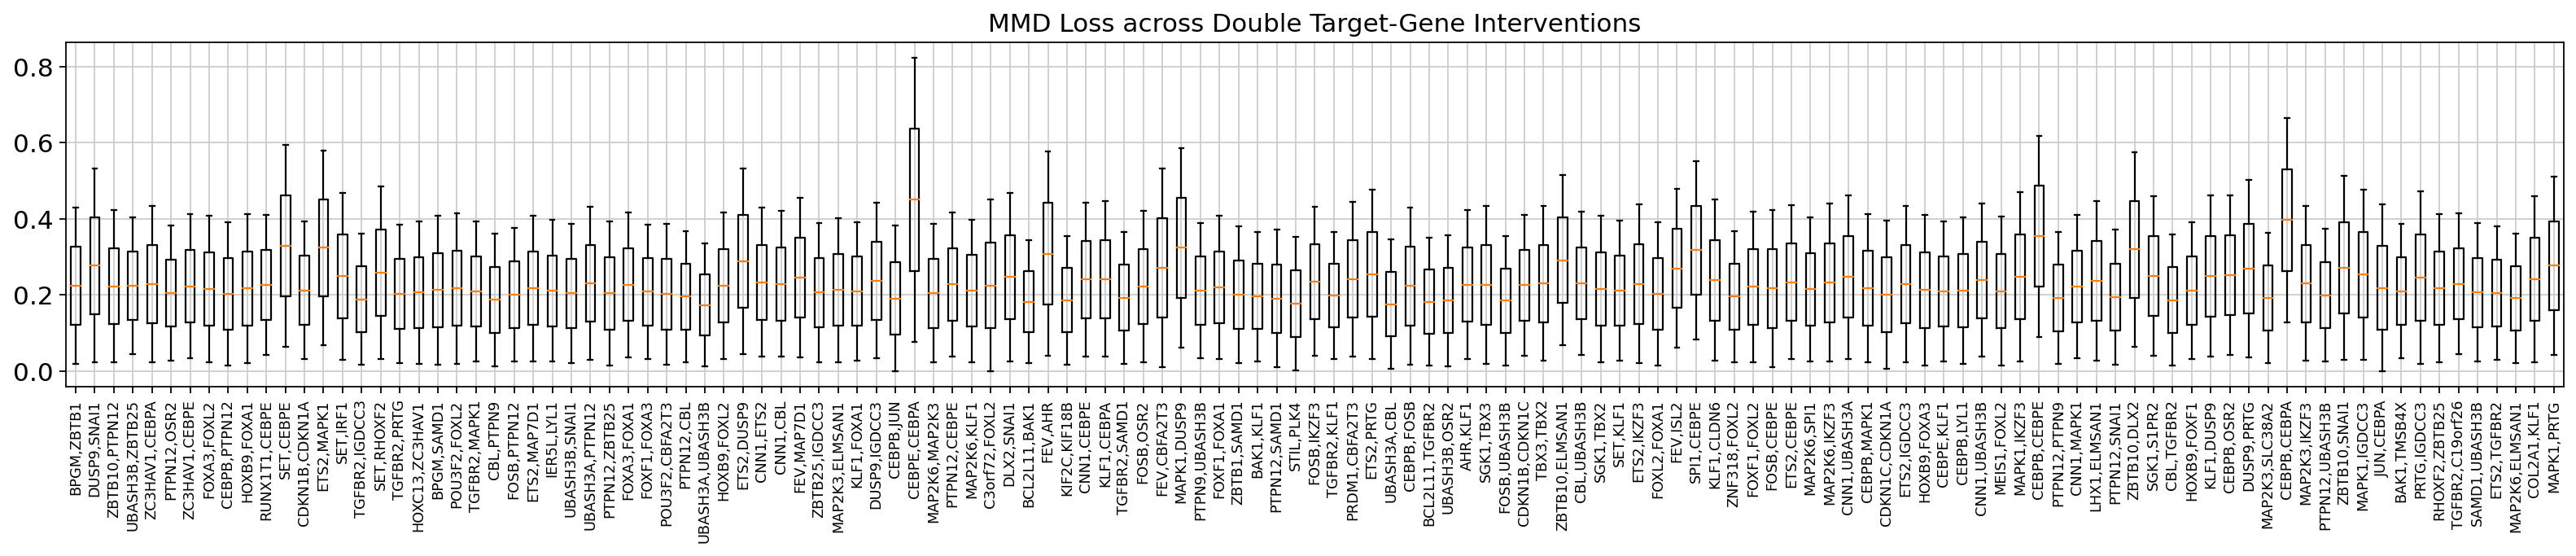

In [27]:
key = set(mmd_loss_summary.keys())
value = [mmd_loss_summary[k] for k in key]

fig, ax = plt.subplots(figsize=(20,4.5))

ax.boxplot(value)
ax.set_xticklabels([','.join([ptb_targets[int(i)] for i in k.split(',')]) for k in key],
                    rotation=90,fontsize=8);
plt.title('MMD Loss across Double Target-Gene Interventions')
plt.tight_layout()
plt.savefig('./figures/mmd_double.pdf')

100%|██████████| 131/131 [00:01<00:00, 70.86it/s]


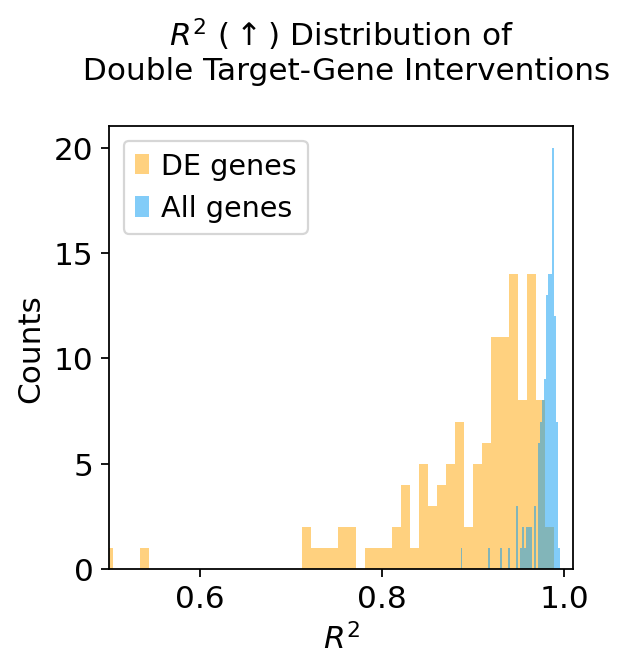

In [28]:
rmse_int = []
rsquare_int = []

rmse_deg = []
rsquare_deg = []

for i in tqdm(set(C_y)):
    k = int(i.split(',')[0])
    l = int(i.split(',')[1])

    gt = gt_y[np.where(c_y[:,k]*c_y[:,l]!=0)[0],:]
    pred = pred_y[np.where(c_y[:,k]*c_y[:,l]!=0)[0],:]
    rmse_int.append(np.sqrt(np.mean(((pred[:] - gt[:])**2)) / np.mean(((gt[:])**2))))
    rsquare_int.append(max(r2_score(np.mean(pred, axis=0),np.mean(gt, axis=0)),0))
    
    g1 = ptb_targets[k]
    g2 = ptb_targets[l]
    for n,name in enumerate(adata.uns['rank_genes_groups']['names'].dtype.names):
        if g1 in name and g2 in name:
            dg = [x[n] for x in adata.uns['rank_genes_groups']['names']]
            break
    idx = [list(adata.var.index).index(deg) for deg in dg]
    

    rmse_deg.append(np.sqrt(np.mean(((pred[:,idx] - gt[:,idx])**2)) / np.mean(((gt[:,idx])**2))))
    rsquare_deg.append(max(r2_score(np.mean(pred[:,idx], axis=0),np.mean(gt[:,idx], axis=0)),0))

plt.figure(figsize=(4,4.5))
plt.hist(rsquare_deg, alpha=.5, label='DE genes', bins=100, color='#FFA500')
plt.hist(rsquare_int, alpha=.5, label='All genes', bins=50, color='#069AF3')
plt.grid(False)
plt.xlabel(r'$R^2$')
plt.ylabel('Counts')
plt.xlim(0.5,1.01)
plt.title(r'$R^2$ ($\uparrow$) Distribution of'+'\n Double Target-Gene Interventions\n')
plt.legend()
plt.tight_layout()
plt.savefig('./figures/r2_double.pdf')

In [29]:
print('R^2')
print('DE genes', np.mean(rsquare_deg))
print('All genes', np.mean(rsquare_int))

R^2
DE genes 0.8679831726719249
All genes 0.9785444569515077


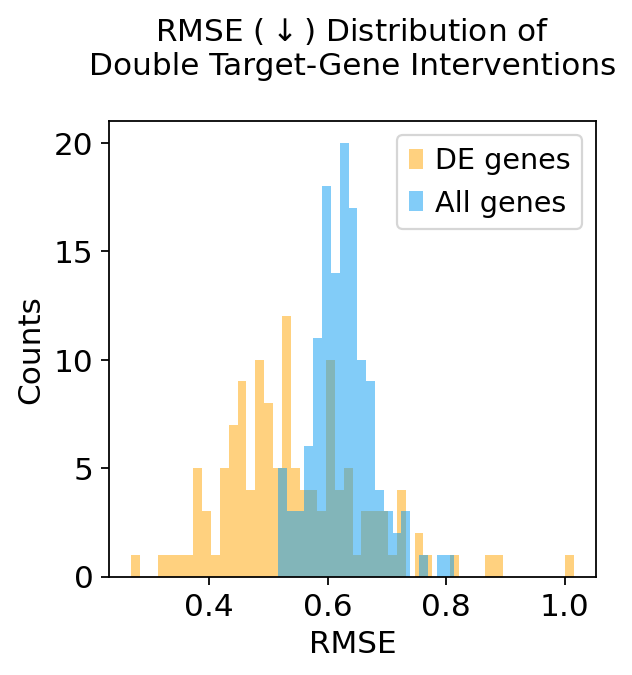

In [30]:
plt.figure(figsize=(4.05,4.5))
plt.hist(rmse_deg, alpha=.5, label='DE genes', bins=50, color='#FFA500')
plt.hist(rmse_int, alpha=.5, label='All genes', bins=20, color='#069AF3')
plt.grid(False)
plt.xlabel('RMSE')
plt.ylabel('Counts')
plt.title(r'RMSE ($\downarrow$) Distribution of'+ '\nDouble Target-Gene Interventions\n')
plt.legend()
plt.tight_layout()
plt.savefig('./figures/rmse_double.pdf')

In [31]:
print('RMSE')
print('DE genes', np.mean(rmse_deg))
print('All genes', np.mean(rmse_int))

RMSE
DE genes 0.5428693345076522
All genes 0.6262806506051575


## 4.3 umap

In [32]:
ctrl_X = adata[~adata.obs['guide_ids'].str.contains(',')].X.toarray()
all_data = np.vstack([ctrl_X, gt_y, pred_y])

adata_new = sc.AnnData(all_data)

sc.tl.pca(adata_new, svd_solver='arpack')
sc.pp.neighbors(adata_new, n_neighbors=30, n_pcs=50)
sc.tl.umap(adata_new, min_dist=0.3) 

computing PCA
    with n_comps=50
    finished (0:00:17)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:28)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:18)


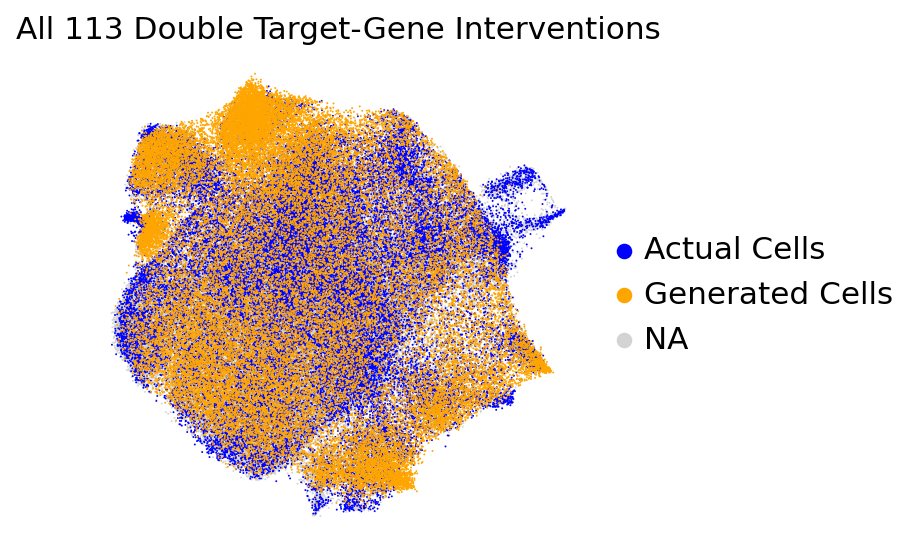

In [34]:
label = ['NA' for _ in range(len(ctrl_X))] + ['Actual Cells' for c in range(len(C_y))] + ['Generated Cells' for _ in range(len(C_y))]
adata_new.obs['label'] = label

sc.pl.umap(adata_new, 
           size=3, color=['label'], 
           groups=['Actual Cells', 'Generated Cells'], 
           legend_fontsize=14, title='All 113 Double Target-Gene Interventions',
           palette={'Actual Cells': 'blue', 
                    'Generated Cells': 'orange',
                    'NA': 'grey'
                   },  
           save=f'_test_double_all.pdf'
          );

In [ ]:
# obtain samples for each pair
for c in tqdm(set(C_y)):
	label = ['NA' for _ in range(len(ctrl_X))] + ['Actual Cells' if C_y[i]==c else 'NA' for i in range(len(C_y))] + ['Generated Cells' if C_y[i]==c else 'NA' for i in range(len(C_y))]
	adata_new.obs['label'] = label
	idx = c.split(',')   
	sc.pl.umap(adata_new, size=30, color=['label'], legend_fontsize=14, 
               groups=['Actual Cells','Generated Cells'], 
               title=f'{ptb_targets[int(idx[0])]}+{ptb_targets[int(idx[1])]}', 
               palette={'Actual Cells': 'blue', 
                    'Generated Cells': 'orange',
                    'NA': 'grey'
                   },  
               legend_loc=None,
               save=f'_test_{ptb_targets[int(idx[0])]}+{ptb_targets[int(idx[1])]}.pdf'
              );

# 5. Training

## 5.1 generate samples

In [36]:
with open(f'{savedir}/train_data.pkl', 'rb') as f:
	train_dataloader = pickle.load(f)

rmse, signerr, gt_y, pred_y, c_y, gt_x = evaluate_generated_samples(model, train_dataloader, model.device, temp=1)
C_y = [','.join([str(l) for l in np.where(c_y[i]!=0)[0]]) for i in range(c_y.shape[0])]

## 5.2 plot statistics

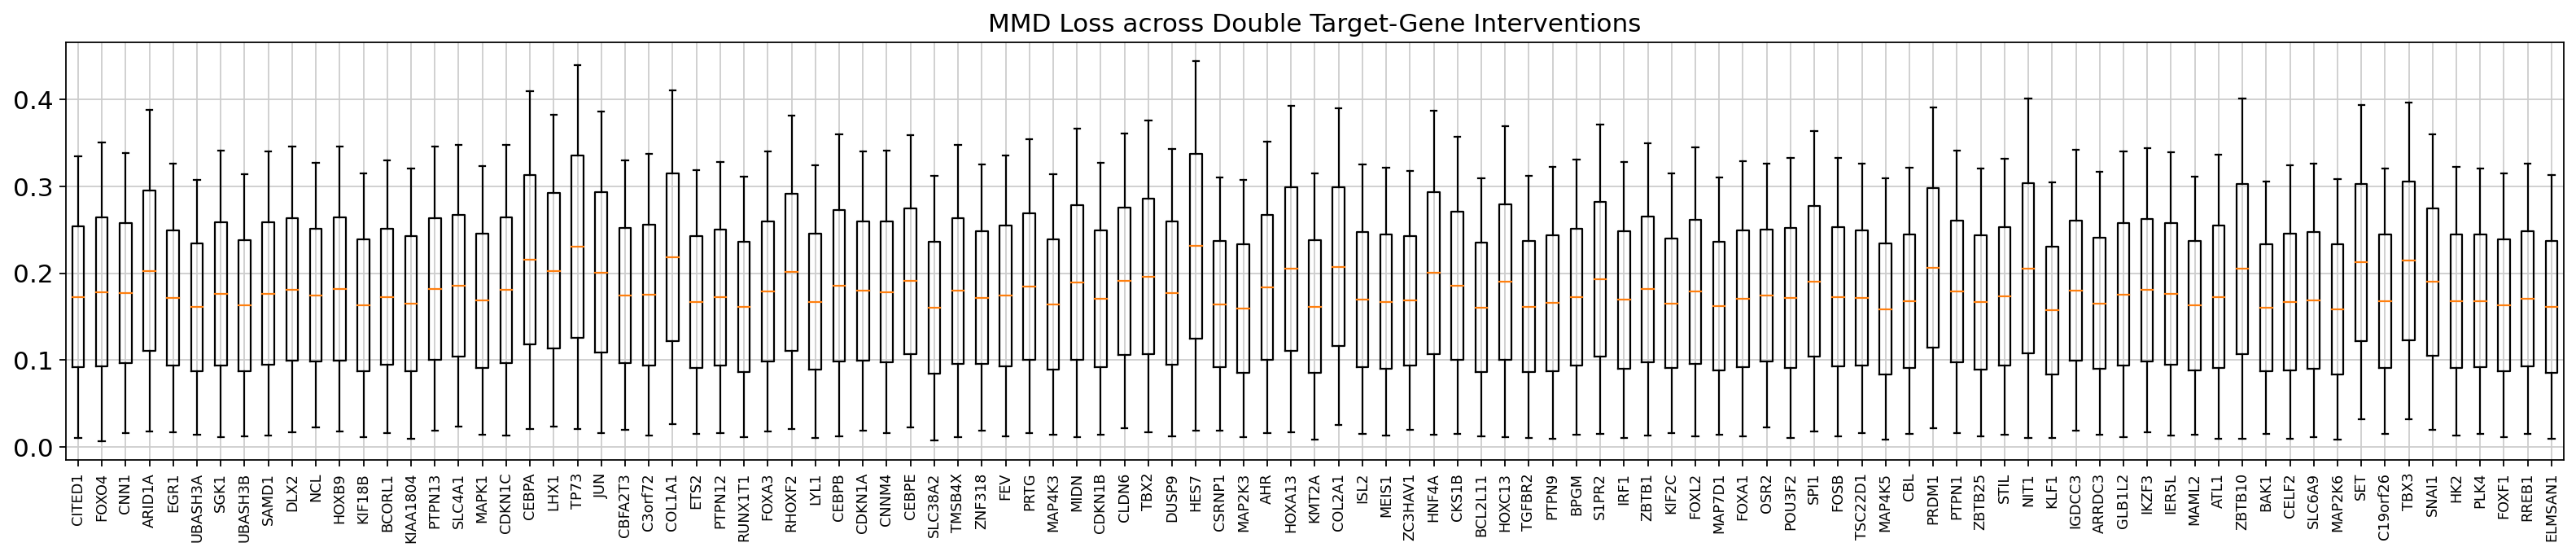

In [41]:
loss =  MMD_loss(fix_sigma=1000, kernel_num=10)

mmd_loss = {}
for i in range(len(C_y)//32):
	y = torch.from_numpy(gt_y[i*32:(i+1)*32])
	y_hat = torch.from_numpy(pred_y[i*32:(i+1)*32])
	c = C_y[i*32]
	if c in mmd_loss.keys():
		mmd_loss[c].append(loss(y_hat, y).item())
	else:
		mmd_loss[c] = [loss(y_hat, y).item()] 

mmd_loss_summary = {}
for k in mmd_loss.keys():
	mmd_loss_summary[k] = (np.average(mmd_loss[k]), np.std(mmd_loss[k]))


key = set(mmd_loss_summary.keys())
value = [mmd_loss_summary[k] for k in key]

fig, ax = plt.subplots(figsize=(20,4.5))

ax.boxplot(value)
ax.set_xticklabels([','.join([ptb_targets[int(i)] for i in k.split(',')]) for k in key],
                    rotation=90,fontsize=8);
plt.title('MMD Loss across Double Target-Gene Interventions')
plt.tight_layout()
plt.savefig('./figures/mmd_single.pdf')

100%|██████████| 105/105 [00:02<00:00, 50.53it/s]


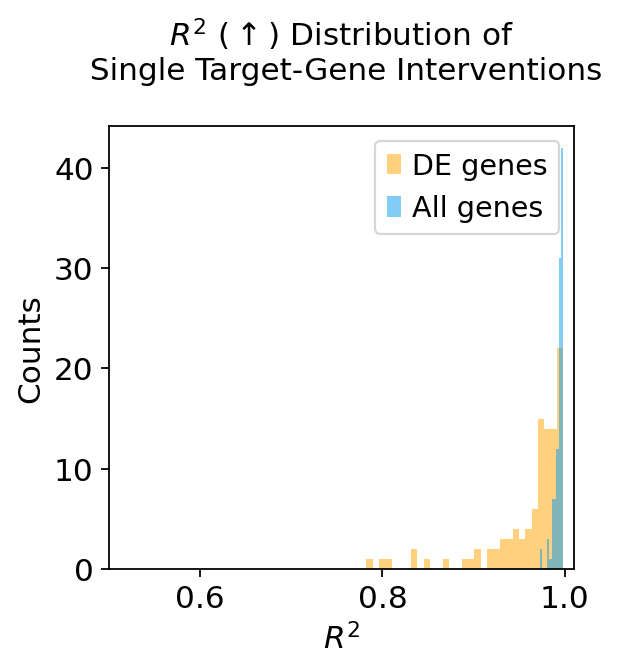

In [42]:
rmse_int = []
rsquare_int = []

rmse_deg = []
rsquare_deg = []

for i in tqdm(set(C_y)):
    k = int(i)

    gt = gt_y[np.where(c_y[:,k]!=0)[0],:]
    pred = pred_y[np.where(c_y[:,k]!=0)[0],:]
    rmse_int.append(np.sqrt(np.mean(((pred[:] - gt[:])**2)) / np.mean(((gt[:])**2))))
    rsquare_int.append(max(r2_score(np.mean(pred, axis=0),np.mean(gt, axis=0)),0))
    
    g1 = ptb_targets[k]
    for n,name in enumerate(adata.uns['rank_genes_groups']['names'].dtype.names):
        if g1 in name:
            dg = [x[n] for x in adata.uns['rank_genes_groups']['names']]
            break
    idx = [list(adata.var.index).index(deg) for deg in dg]
    

    rmse_deg.append(np.sqrt(np.mean(((pred[:,idx] - gt[:,idx])**2)) / np.mean(((gt[:,idx])**2))))
    rsquare_deg.append(max(r2_score(np.mean(pred[:,idx], axis=0),np.mean(gt[:,idx], axis=0)),0))

plt.figure(figsize=(4,4.5))
plt.hist(rsquare_deg, alpha=.5, label='DE genes', bins=100, color='#FFA500')
plt.hist(rsquare_int, alpha=.5, label='All genes', bins=10, color='#069AF3')
plt.grid(False)
plt.xlabel(r'$R^2$')
plt.ylabel('Counts')
plt.xlim(0.5,1.01)
plt.title(r'$R^2$ ($\uparrow$) Distribution of'+'\n Single Target-Gene Interventions\n')
plt.legend()
plt.tight_layout()
plt.savefig('./figures/r2_single.pdf')

In [43]:
print('R^2')
print('DE genes', np.mean(rsquare_deg))
print('All genes', np.mean(rsquare_int))

R^2
DE genes 0.9507500560710352
All genes 0.994074861948699


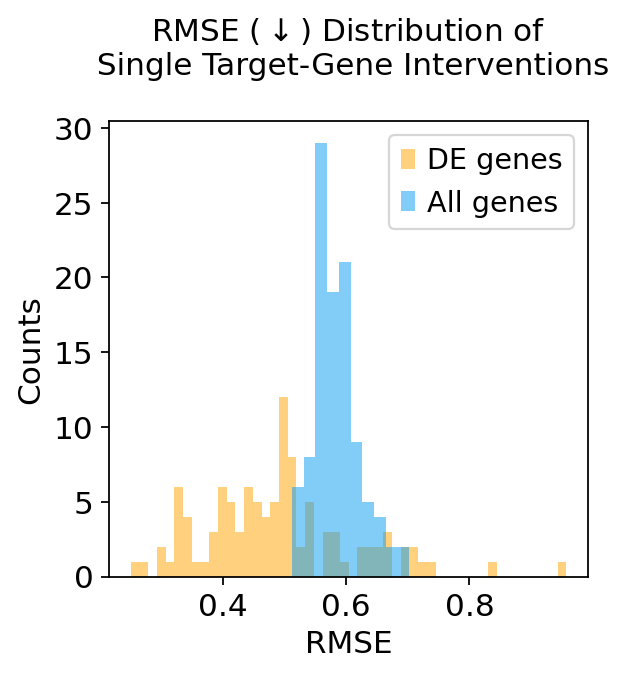

In [44]:
plt.figure(figsize=(4,4.5))
plt.hist(rmse_deg, alpha=.5, label='DE genes', bins=50, color='#FFA500')
plt.hist(rmse_int, alpha=.5, label='All genes', bins=10, color='#069AF3')
plt.grid(False)
plt.xlabel('RMSE')
plt.ylabel('Counts')
plt.title(r'RMSE ($\downarrow$) Distribution of'+ '\n Single Target-Gene Interventions\n')
plt.legend()
plt.tight_layout()
plt.savefig('./figures/rmse_single.pdf')

In [45]:
print('RMSE')
print('DE genes', np.mean(rmse_deg))
print('All genes', np.mean(rmse_int))

RMSE
DE genes 0.4894965475854987
All genes 0.583386801457334


## 5.3 umap

In [37]:
ctrl_X = adata[~adata.obs['guide_ids'].isin(ptb_targets)].X.toarray()
all_data = np.vstack([ctrl_X, gt_y, pred_y])

adata_new = sc.AnnData(all_data)

sc.tl.pca(adata_new, svd_solver='arpack')
sc.pp.neighbors(adata_new, n_neighbors=30, n_pcs=50)
sc.tl.umap(adata_new, min_dist=0.3) 

computing PCA
    with n_comps=50
    finished (0:00:23)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:31)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:26)


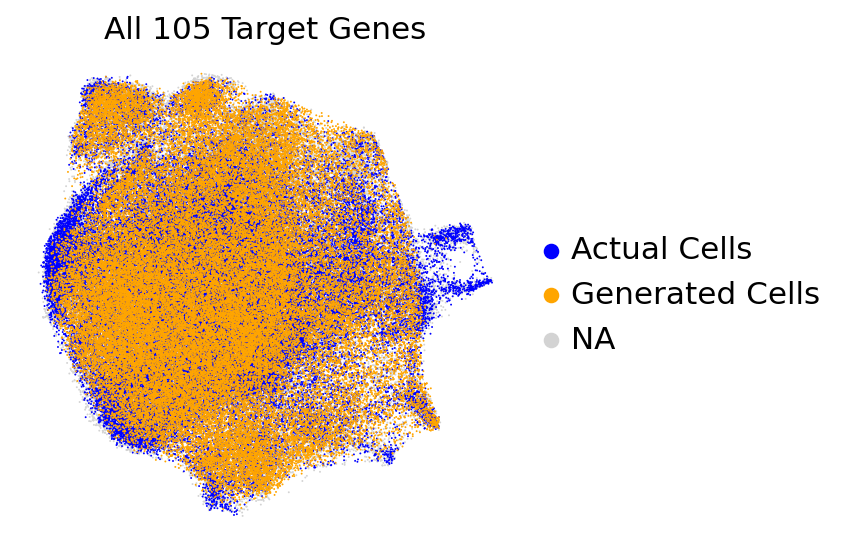

In [38]:
label = ['NA' for _ in range(len(ctrl_X))] + ['Actual Cells' for c in range(len(C_y))] + ['Generated Cells' for _ in range(len(C_y))]
adata_new.obs['label'] = label

sc.pl.umap(adata_new, 
           size=3, color=['label'], 
           groups=['Actual Cells', 'Generated Cells'], 
           legend_fontsize=14, title='All 105 Target Genes', 
           palette={'Actual Cells': 'blue', 
                    'Generated Cells': 'orange',
                    'NA': 'grey'
                   },  
#            save=f'_train_all.pdf'
          );


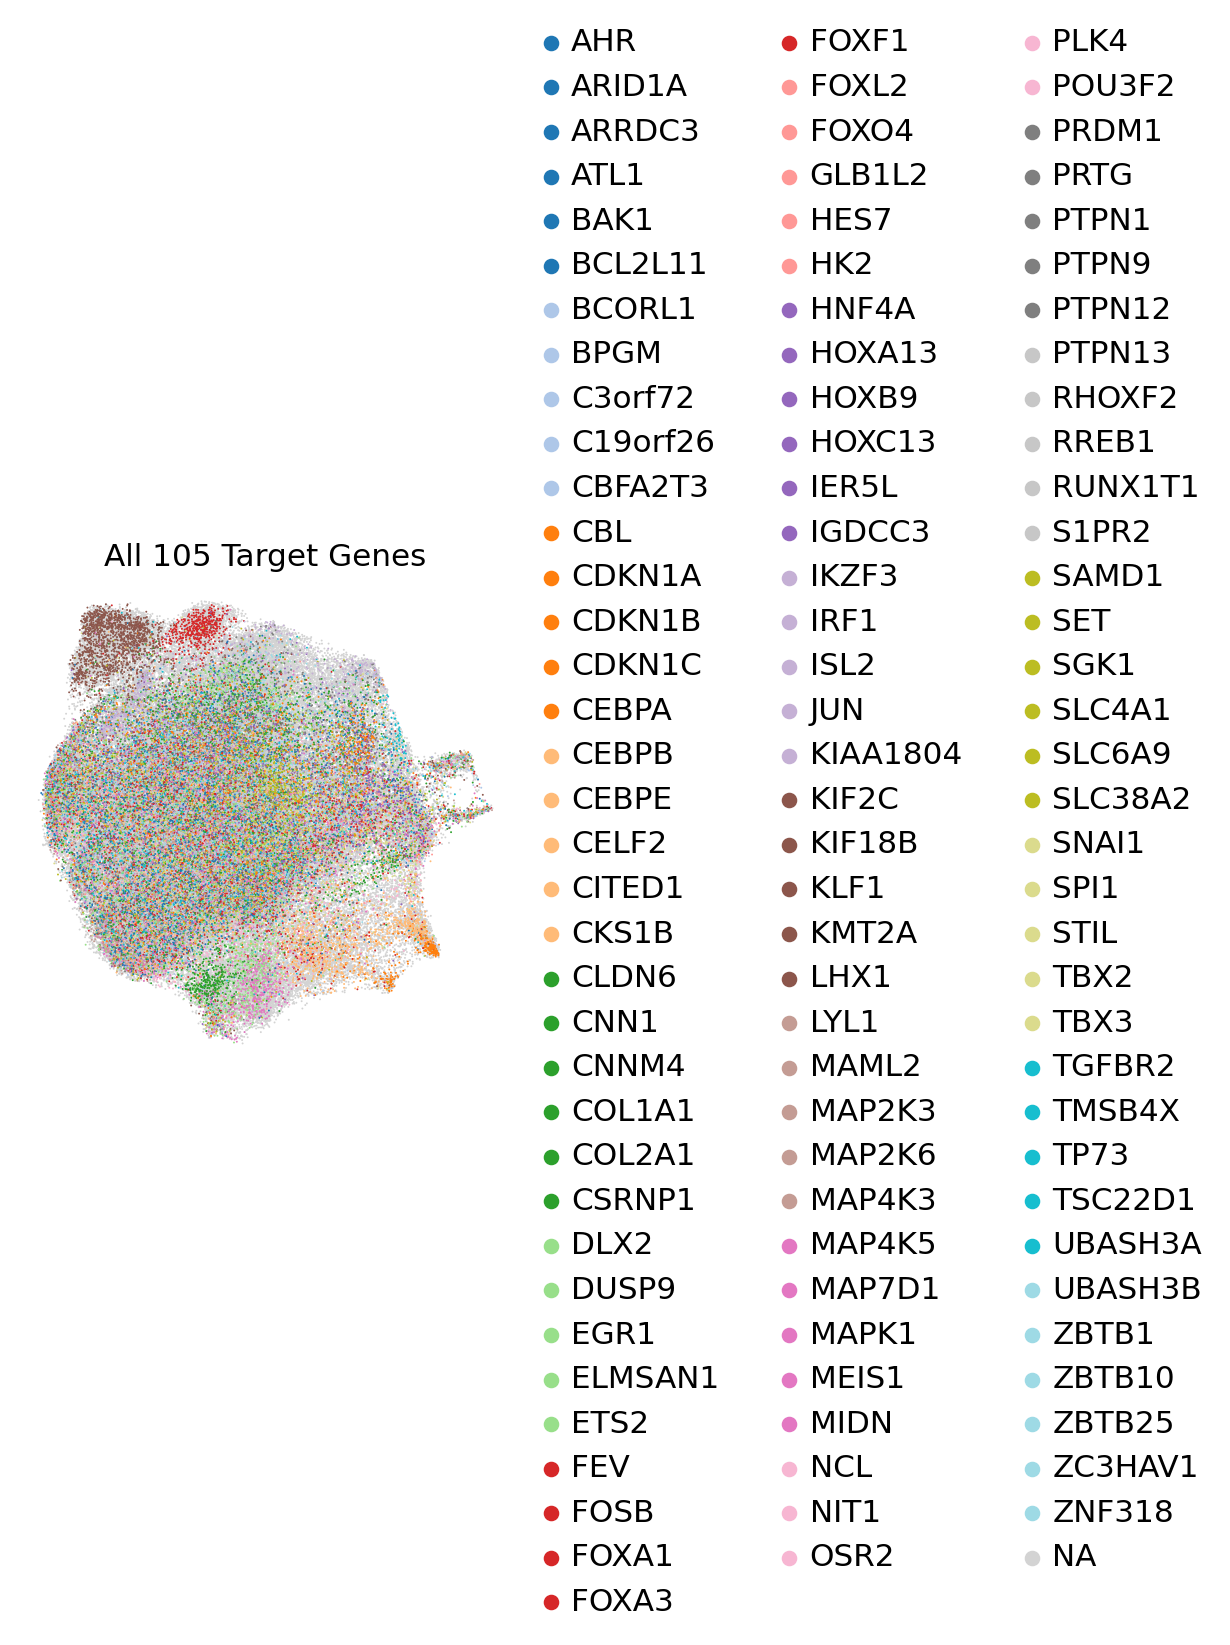

In [39]:
guide_ids = ['NA' for _ in range(len(ctrl_X))] + [ptb_targets[int(c)] for c in C_y] + ['NA' for _ in range(len(C_y))]
adata_new.obs['guide_ids'] = guide_ids

sc.pl.umap(adata_new, 
           size=3, color=['guide_ids'], 
           groups=ptb_targets,
           legend_fontsize=14, title='All 105 Target Genes',
           palette='tab20',
        #    save=f'_train_all_guide.pdf'
          );

In [ ]:
# obtain side-by-side umaps
for c in [str(i) for i in range(105)]:
	label1 = ['NA' for _ in range(len(ctrl_X))] + ['Actual Cells' if C_y[i]==c else 'NA' for i in range(len(C_y))] + ['NA' if C_y[i]==c else 'NA' for i in range(len(C_y))]
	label2 = ['NA' for _ in range(len(ctrl_X))] + ['NA' if C_y[i]==c else 'NA' for i in range(len(C_y))] + ['Generated Cells' if C_y[i]==c else 'NA' for i in range(len(C_y))]
	adata_new.obs['label1'] = label1
	adata_new.obs['label2'] = label2
	sc.pl.umap(adata_new, size=20, color=['label1','label2'], 
               legend_fontsize=14, 
               groups=['Actual Cells','Generated Cells'],
               ncols=2,
               title=[f'{ptb_targets[int(c)]}: Actual Cells',f'{ptb_targets[int(c)]}: Generated Cells'], 
               palette={'Actual Cells': 'blue', 
                        'Generated Cells': 'orange',
                        'NA': 'grey'
                       },
               legend_loc=None,  
        #        save=f'_train_{ptb_targets[int(c)]}.pdf'
              );